In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error
import dash
from dash import dcc, html, Input, Output
import plotly.express as px

In [2]:
import dash

In [3]:
path = 'covid.csv'
df = pd.read_csv(path)

In [6]:
df.head(100)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0,0,0,Africa
...,...,...,...,...,...,...,...,...,...,...
95,NaN,Ecuador,-1.831200,-78.183400,2020-01-22,0,0,0,0,Americas
96,NaN,Egypt,26.820553,30.802498,2020-01-22,0,0,0,0,Eastern Mediterranean
97,NaN,El Salvador,13.794200,-88.896500,2020-01-22,0,0,0,0,Americas
98,NaN,Equatorial Guinea,1.650800,10.267900,2020-01-22,0,0,0,0,Africa


In [5]:
print(df)

      Province/State         Country/Region        Lat       Long        Date  \
0                NaN            Afghanistan  33.939110  67.709953  2020-01-22   
1                NaN                Albania  41.153300  20.168300  2020-01-22   
2                NaN                Algeria  28.033900   1.659600  2020-01-22   
3                NaN                Andorra  42.506300   1.521800  2020-01-22   
4                NaN                 Angola -11.202700  17.873900  2020-01-22   
...              ...                    ...        ...        ...         ...   
49063            NaN  Sao Tome and Principe   0.186400   6.613100  2020-07-27   
49064            NaN                  Yemen  15.552727  48.516388  2020-07-27   
49065            NaN                Comoros -11.645500  43.333300  2020-07-27   
49066            NaN             Tajikistan  38.861000  71.276100  2020-07-27   
49067            NaN                Lesotho -29.610000  28.233600  2020-07-27   

       Confirmed  Deaths  R

In [ ]:
import pandas as pd

def load_and_preprocess_data(covid_data, worldometer_data, full_grouped_data, country_wise_latest):
    try:
        # Merge datasets with unique suffixes
        merged_data = covid_data.merge(
            worldometer_data, on='Country/Region', how='left', suffixes=('', '_worldometer')
        )
        
        merged_data = merged_data.merge(
            full_grouped_data, on=['Country/Region', 'Date'], how='left', suffixes=('', '_grouped')
        )
        
        merged_data = merged_data.merge(
            country_wise_latest, on='Country/Region', how='left', suffixes=('', '_latest')
        )

        # Drop duplicate
        duplicate_columns = ['WHO Region_worldometer', 'WHO Region_grouped', 'WHO Region_latest']
        merged_data = merged_data.loc[:, ~merged_data.columns.isin(duplicate_columns)]

        # Handle missing values
        merged_data.ffill(inplace=True)  
        merged_data.fillna(0, inplace=True)  

        # Convert 'Date' to datetime
        merged_data['Date'] = pd.to_datetime(merged_data['Date'])

        return merged_data

    except Exception as e:
        print(f"Error loading data: {e}")
        return None
# Load and preprocess the data
data = load_and_preprocess_data(covid_data, worldometer_data, full_grouped_data, country_wise_latest)

In [18]:
covid_data = df
worldometer_data = pd.read_csv("worldometer_data.csv")
country_wise_latest = pd.read_csv("country_wise_latest.csv")


In [20]:
full_grouped_data = pd.read_csv("full_grouped.csv")

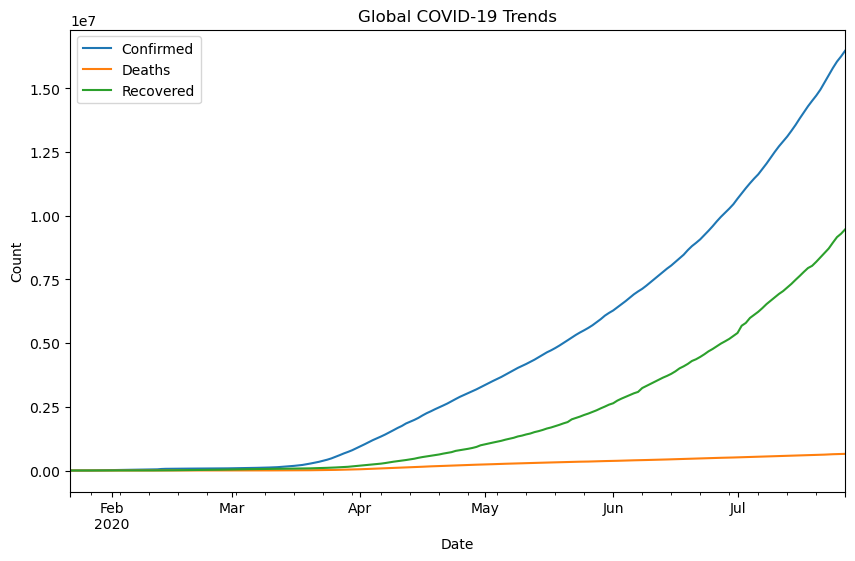

c:\Users\PLAYHOUSE\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PLAYHOUSE\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PLAYHOUSE\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PLAYHOUSE\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\PLAYHOUSE\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood o

                               SARIMAX Results                                
Dep. Variable:              Confirmed   No. Observations:                  150
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1556.845
Date:                Tue, 03 Dec 2024   AIC                           3123.690
Time:                        07:47:15   BIC                           3138.710
Sample:                    01-22-2020   HQIC                          3129.792
                         - 06-19-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0596      0.292      3.626      0.000       0.487       1.632
ar.L2         -0.0596      0.289     -0.206      0.837      -0.626       0.507
ma.L1         -0.2069      0.286     -0.723      0.4

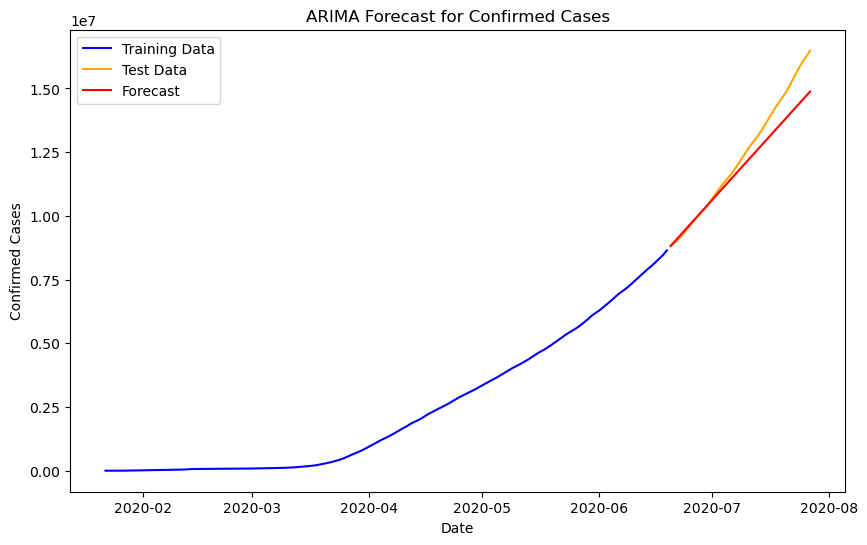

In [22]:
def time_series_analysis(df):
    global_trends = df.groupby('Date')[['Confirmed', 'Deaths', 'Recovered']].sum()
    
    global_trends.plot(figsize=(10, 6), title='Global COVID-19 Trends')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.show()

    time_series = global_trends['Confirmed']
    train_size = int(len(time_series) * 0.8)
    train, test = time_series[:train_size], time_series[train_size:]

    model = ARIMA(train, order=(2, 1, 2))
    model_fit = model.fit()
    print(model_fit.summary())

    # Forecast
    forecast = model_fit.forecast(steps=len(test))
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    print(f"MAE: {mae}, RMSE: {rmse}")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label='Training Data', color='blue')
    plt.plot(test.index, test, label='Test Data', color='orange')
    plt.plot(test.index, forecast, label='Forecast', color='red')
    plt.xlabel('Date')
    plt.ylabel('Confirmed Cases')
    plt.legend()
    plt.title('ARIMA Forecast for Confirmed Cases')
    plt.show()


if data is not None:
    time_series_analysis(data)

In [23]:
consolidated_data = data

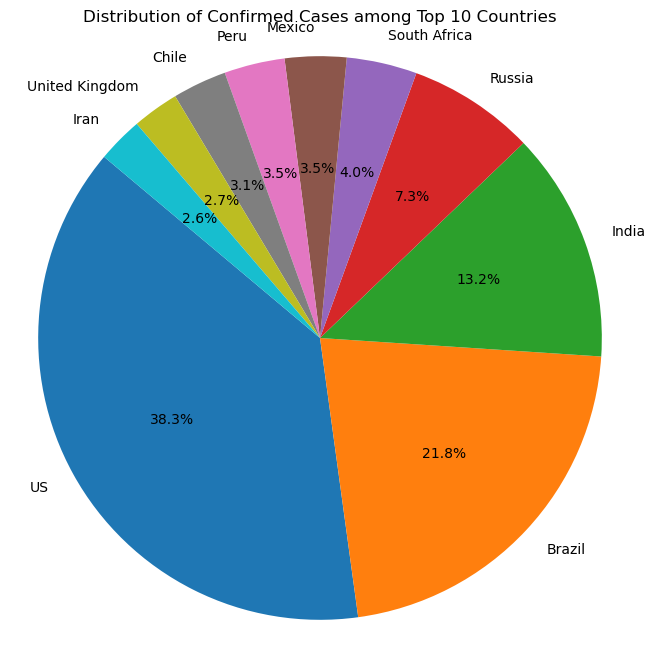

In [32]:
top_countries = df.groupby('Country/Region')['Confirmed'].max().nlargest(10)

plt.figure(figsize=(8, 8))
plt.pie(top_countries, labels=top_countries.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Confirmed Cases among Top 10 Countries')
plt.axis('equal')
plt.show()

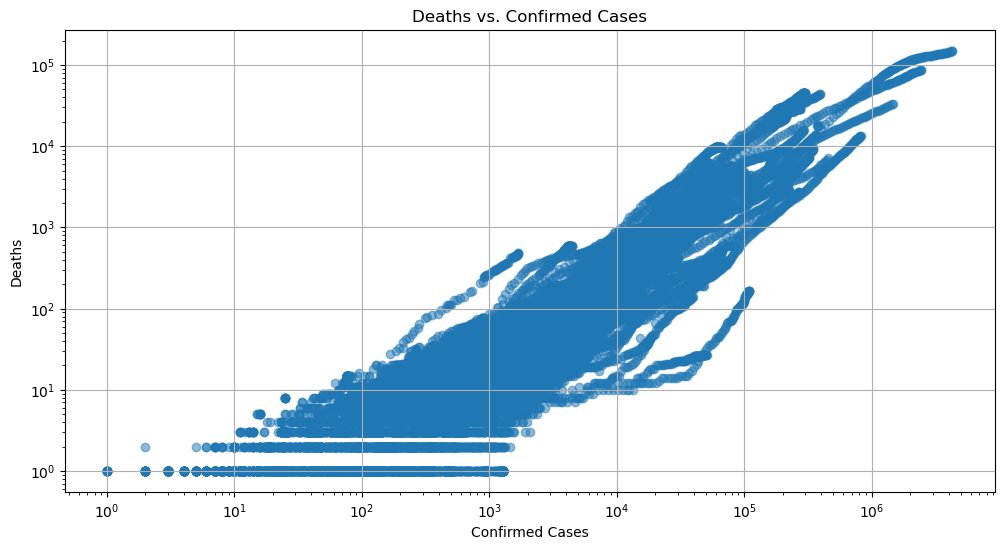

In [33]:
plt.figure(figsize=(12, 6))
plt.scatter(df['Confirmed'], df['Deaths'], alpha=0.5)
plt.xlabel('Confirmed Cases')
plt.ylabel('Deaths')
plt.title('Deaths vs. Confirmed Cases')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()

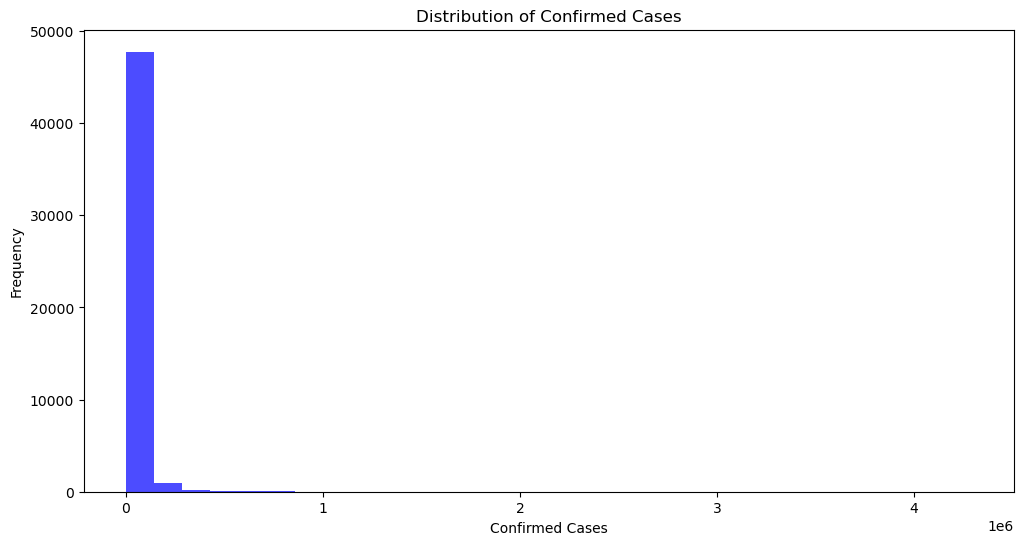

In [34]:
plt.figure(figsize=(12, 6))
plt.hist(df['Confirmed'], bins=30, color='blue', alpha=0.7)
plt.xlabel('Confirmed Cases')
plt.ylabel('Frequency')
plt.title('Distribution of Confirmed Cases')
plt.show()

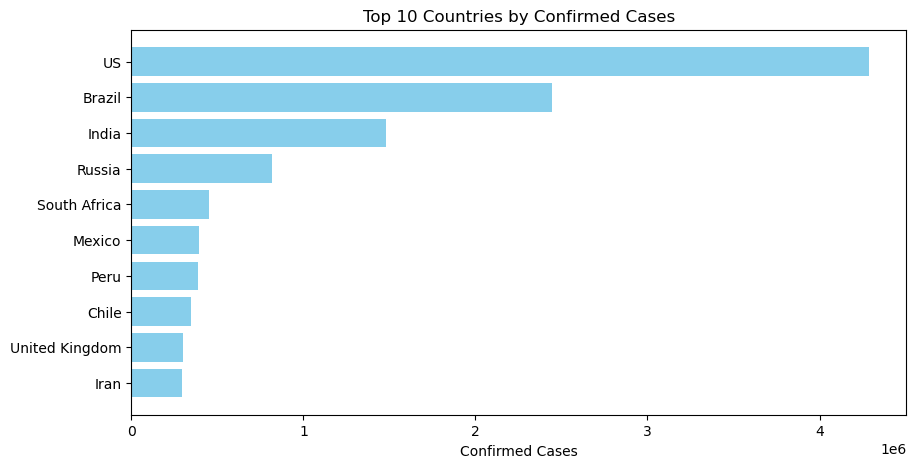

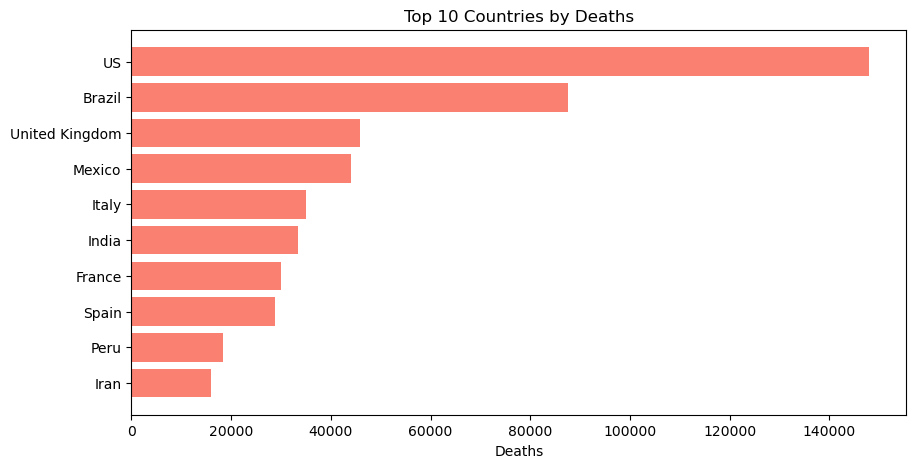

In [24]:
latest_data = consolidated_data.groupby('Country/Region')[['Confirmed', 'Deaths', 'Recovered']].max().fillna(0)

top_10_cases = latest_data.nlargest(10, 'Confirmed')
top_10_deaths = latest_data.nlargest(10, 'Deaths')

plt.figure(figsize=(10, 5))
plt.barh(top_10_cases.index, top_10_cases['Confirmed'], color='skyblue')
plt.xlabel('Confirmed Cases')
plt.title('Top 10 Countries by Confirmed Cases')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10, 5))
plt.barh(top_10_deaths.index, top_10_deaths['Deaths'], color='salmon')
plt.xlabel('Deaths')
plt.title('Top 10 Countries by Deaths')
plt.gca().invert_yaxis()
plt.show()

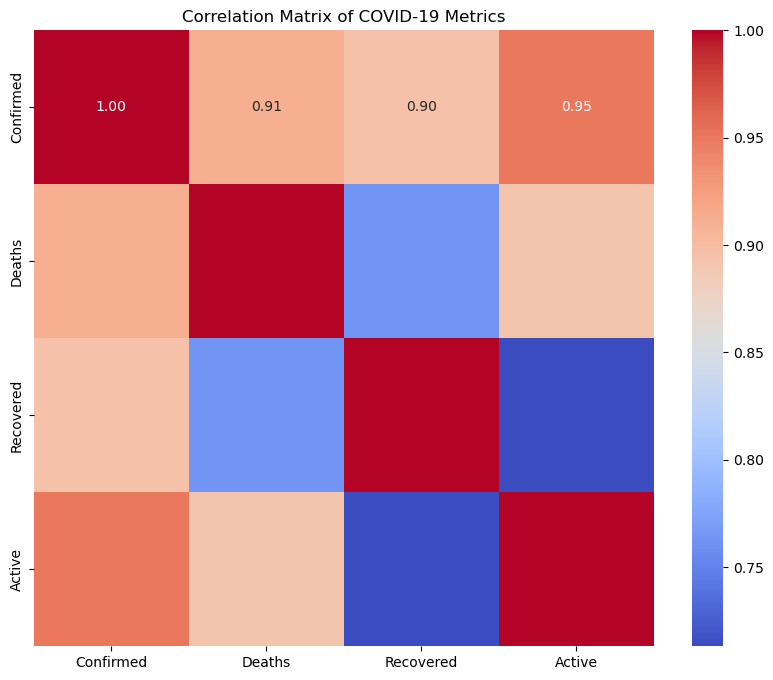

In [35]:
import seaborn as sns

filtered_data = df[['Confirmed', 'Deaths', 'Recovered', 'Active']]
corr_matrix = filtered_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of COVID-19 Metrics')
plt.show()

<Figure size 1200x600 with 0 Axes>

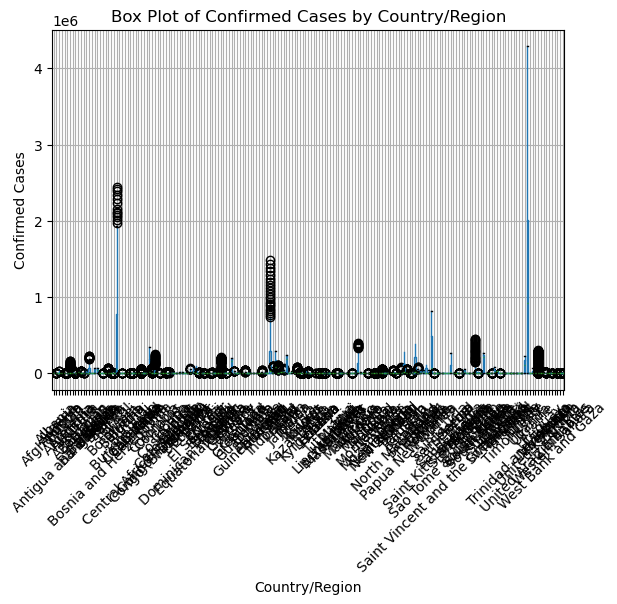

In [36]:
plt.figure(figsize=(12, 6))
df.boxplot(column='Confirmed', by='Country/Region', rot=45)
plt.title('Box Plot of Confirmed Cases by Country/Region')
plt.suptitle('')
plt.ylabel('Confirmed Cases')
plt.show()

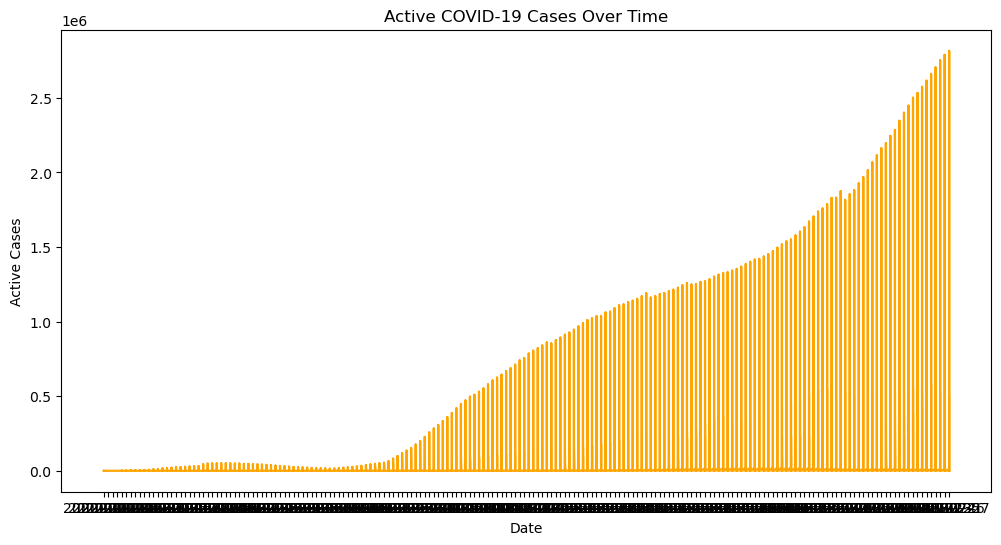

In [37]:
plt.figure(figsize=(12, 6))
plt.fill_between(df['Date'], df['Active'], color='orange', alpha=0.5)
plt.plot(df['Date'], df['Active'], color='orange')
plt.xlabel('Date')
plt.ylabel('Active Cases')
plt.title('Active COVID-19 Cases Over Time')
plt.show()

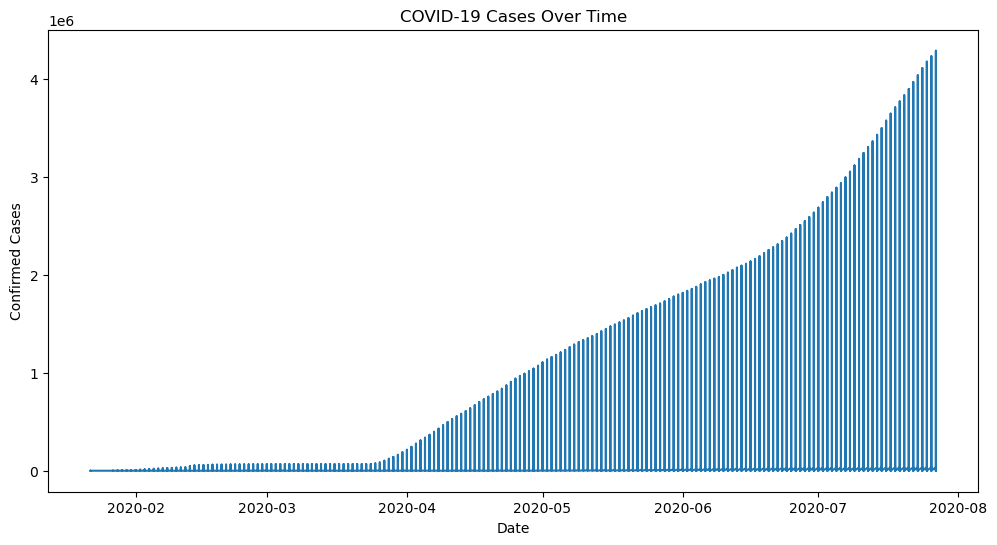

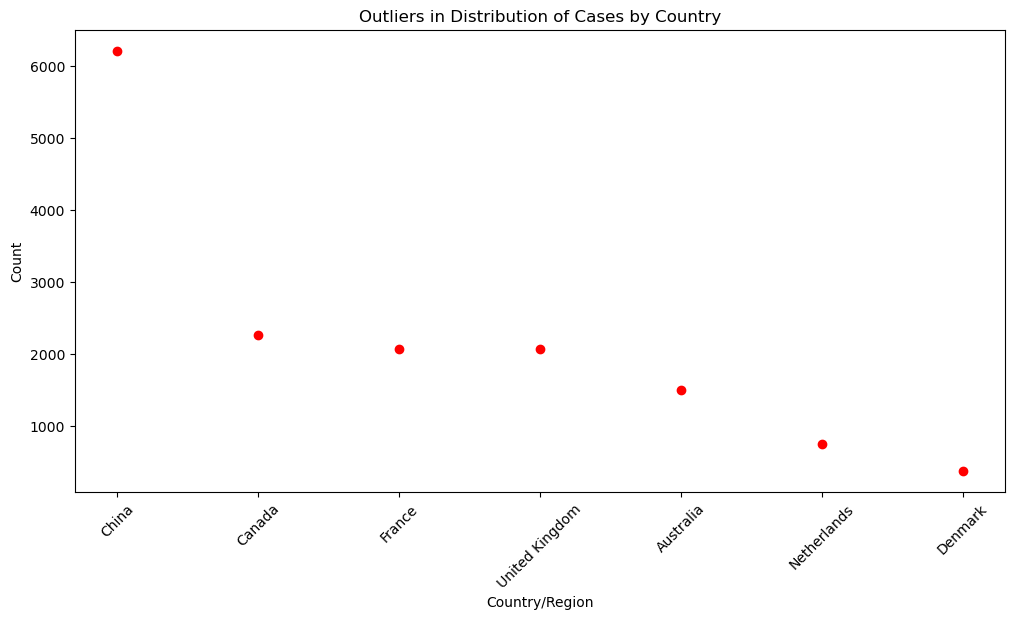

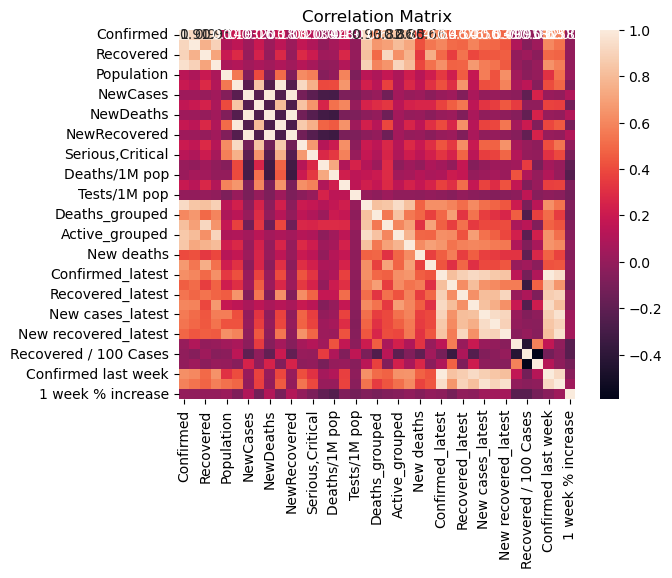

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Confirmed'])
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title('COVID-19 Cases Over Time')
plt.show()

country_counts = data['Country/Region'].value_counts().reset_index()
country_counts.columns = ['Country/Region', 'Count']

Q1 = country_counts['Count'].quantile(0.25)
Q3 = country_counts['Count'].quantile(0.75)
IQR = Q3 - Q1

outliers = country_counts[(country_counts['Count'] < (Q1 - 1.5 * IQR)) | (country_counts['Count'] > (Q3 + 1.5 * IQR))]

plt.figure(figsize=(12, 6))
plt.scatter(outliers['Country/Region'], outliers['Count'], color='red')
plt.xticks(rotation=45)
plt.xlabel('Country/Region')
plt.ylabel('Count')
plt.title('Outliers in Distribution of Cases by Country')
plt.show()

filtered_data = data.drop(columns=['Long', 'Lat'])

corr_matrix = filtered_data.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

c:\Users\PLAYHOUSE\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


MAE: 502215.7114398795, RMSE: 710226.2767302527


c:\Users\PLAYHOUSE\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


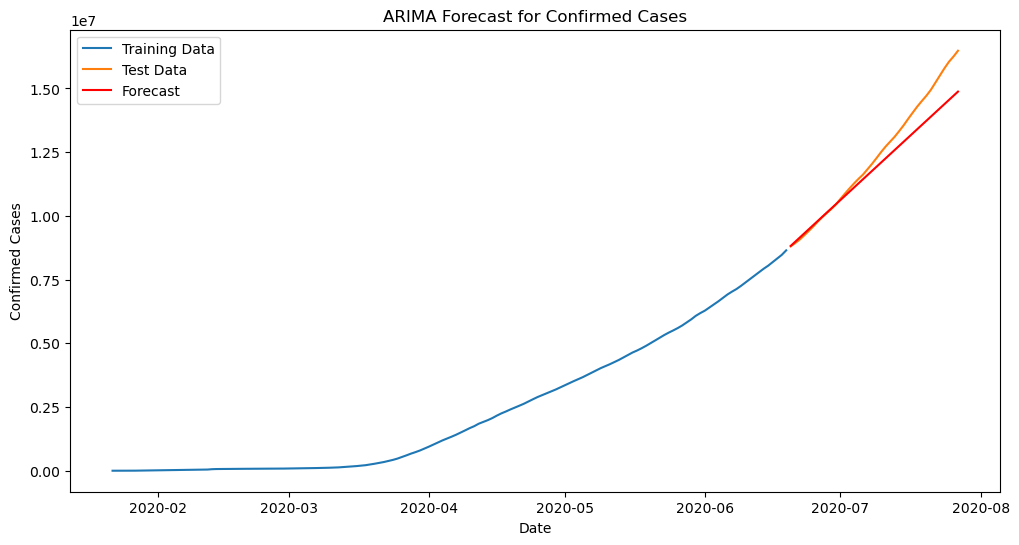

In [29]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.groupby('Date').agg({
    'Confirmed': 'sum',
    'Deaths': 'sum',
    'Recovered': 'sum',
    'Active': 'sum'
}).reset_index()

# Train-test split
train_size = int(len(data) * 0.8)
train, test = data['Confirmed'][:train_size], data['Confirmed'][train_size:]

# Fit ARIMA model
model = ARIMA(train, order=(2, 1, 2))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f'MAE: {mae}, RMSE: {rmse}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(data['Date'][:train_size], train, label='Training Data')
plt.plot(data['Date'][train_size:], test, label='Test Data')
plt.plot(data['Date'][train_size:], forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast for Confirmed Cases')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.show()

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create a binary target variable based on a confirmed cases threshold
threshold = 100000
data['High_Cases'] = (data['Confirmed'] > threshold).astype(int)

# Prepare features and target variable
X = data[['Deaths', 'Recovered', 'Active']]  # Features
y = data['High_Cases']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Logistic Regression model
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Predictions
y_pred = classifier.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}')

Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
